# Importing Necessary Libraries

In [38]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Loading the dataset

In [40]:
data = pd.read_csv('Downloads/hate.csv (1)/hate.csv', encoding='latin1')  
data = data.drop(['Unnamed: 0'], axis=1)

In [41]:
data

,comment,label
0,dalits are lowlives,N
1,gay people are a burden to our society,N
2,Arabs are not welcome,N
3,I'm not saying we should actually eliminate he...,N
4,bananas are for black people,N
...,...,...
41139,Indian culture is so backwards,N
41140,"Women don't want equality, they just want to b...",N
41141,fuck covid,P
41142,This computer is garbage,P


# Exploring the Data

In [42]:
print(data.head())

                                             comment label
0                                dalits are lowlives     N
1             gay people are a burden to our society     N
2                              Arabs are not welcome     N
3  I'm not saying we should actually eliminate he...     N
4                       bananas are for black people     N


In [43]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41144 entries, 0 to 41143
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  41144 non-null  object
 1   label    41144 non-null  object
dtypes: object(2)
memory usage: 643.0+ KB
None


# Checking Distribution of Labels

In [44]:
# Remove rows where label is 'O'
df_filtered = data[data['label'] != 'O']
print(df_filtered['label'].value_counts())  # Check the distribution of labels

label
N    22158
P    18950
Name: count, dtype: int64


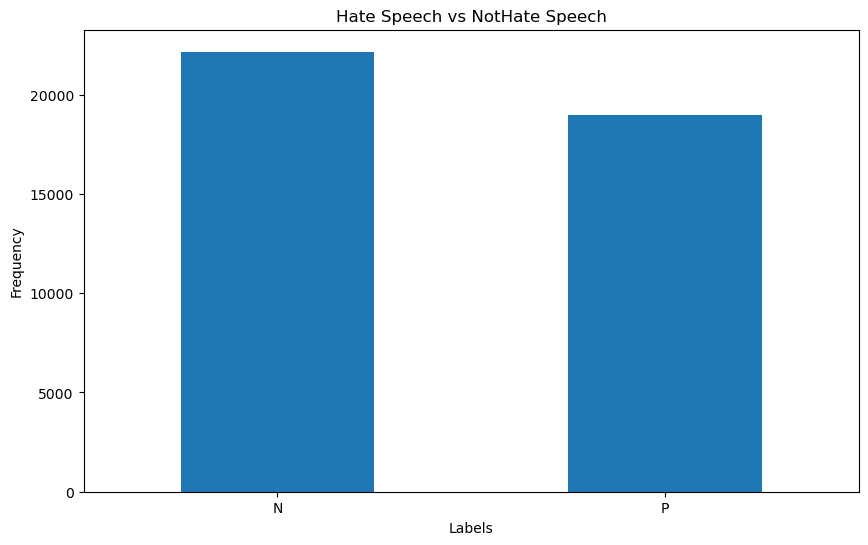

In [45]:
import matplotlib.pyplot as plt
# Count the occurrences of each label
label_counts = df_filtered['label'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Hate Speech vs NotHate Speech')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


In [46]:
data.isnull().any()

comment    False
label      False
dtype: bool

# checking for Duplicates

In [47]:
# Check for duplicates
duplicates = df_filtered.duplicated().sum()
print("\nNumber of duplicate rows:", duplicates)


Number of duplicate rows: 10


In [48]:
if duplicates > 0:
    print("\nSample of duplicate rows:\n")
    print(data[data.duplicated()].head())


Sample of duplicate rows:

                        comment label
41047  Blacks are such pondlife     N
41048  Blacks are such pondlife     N
41051  Blacks are such pondlife     N
41055  Blacks are such pondlife     N
41094    Muslims are a disgrace     N


In [49]:
# Remove duplicates
data = df_filtered.drop_duplicates()
print("\nDuplicates removed. Number of rows now:", len(data))


Duplicates removed. Number of rows now: 41098


# Importing Necessary nltk Packages

In [50]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Text Cleaning

#### The `clean_text` function standardizes and cleans textual data by converting all characters to lowercase, removing non-word characters using a regular expression to replace them with spaces, and eliminating extra whitespace. This preprocessing step ensures the text is uniform and free of unwanted characters, making it more suitable for further analysis or processing.

In [51]:
import re

# Comprehensive dictionary of common contractions and chat language words
contractions_dict = {
    "i'm": "i am",
    "i've": "i have",
    "i'll": "i will",
    "i'd": "i would",
    "you're": "you are",
    "you've": "you have",
    "you'll": "you will",
    "you'd": "you would",
    "he's": "he is",
    "he'll": "he will",
    "he'd": "he would",
    "she's": "she is",
    "she'll": "she will",
    "she'd": "she would",
    "it's": "it is",
    "it'll": "it will",
    "we're": "we are",
    "we've": "we have",
    "we'll": "we will",
    "we'd": "we would",
    "they're": "they are",
    "they've": "they have",
    "they'll": "they will",
    "they'd": "they would",
    "that's": "that is",
    "there's": "there is",
    "there'll": "there will",
    "there'd": "there would",
    "who's": "who is",
    "who'll": "who will",
    "who'd": "who would",
    "what's": "what is",
    "where's": "where is",
    "when's": "when is",
    "why's": "why is",
    "how's": "how is",
    "let's": "let us",
    "d'you": "do you",
    "d'ya": "do you",
    "can't": "cannot",
    "won't": "will not",
    "don't": "do not",
    "didn't": "did not",
    "hasn't": "has not",
    "haven't": "have not",
    "hadn't": "had not",
    "doesn't": "does not",
    "isn't": "is not",
    "aren't": "are not",
    "wasn't": "was not",
    "weren't": "were not",
    "ain't": "is not",
    "wouldn't": "would not",
    "shouldn't": "should not",
    "couldn't": "could not",
    "mightn't": "might not",
    "mustn't": "must not",
    "needn't": "need not",
    "shan't": "shall not",
    "ma'am": "madam",
    "o'clock": "of the clock",
    "y'all": "you all",
    "n't": " not",
    "'re": " are",
    "'s": " is",
    "'d": " would",
    "'ll": " will",
    "'t": " not",
    "'ve": " have",
    "'m": " am",
    "y": "why",
    "tbh": "to be honest",
    "nah": "no",
    "whats'upp": "what is up",
    "im": "i am",
    "he'd":"he would",
    "WMAF":"White Male Asian Female",
    "lol":"laugh out loud",
    "lmao":"laughing my ass off",
    "BRB": "Be right back",
    "OMG": "Oh my God",
    "ASAP":" As soon as possible",
    "btw" : "By the way",
    "idk" : "I don't know",
    "ttyl": "Talk to you later",
    "lmk": "Let me know",
    "fyi": "For your information",
    "NVM":" Nevermind",
    "IMO":" In my opinion",
    "g@y" : "gay",
    "stup!d" : "stupid",
    "ROFL": "Rolling on the floor laughing",
    "THX": "Thanks",
    "WBU":" What about you?",
    "YOLO": "You only live once",
    "JK" :"Just kidding",
    "bc" :"Because",
    "sry" : "Sorry",
    "spk" : "Speak",
    "N" : "and",
    "blm" : "blame",
    "m3n" : "men",
    
}

def expand_contractions(text, contractions_dict):
    pattern = re.compile(r'\b(' + '|'.join(re.escape(key) for key in contractions_dict.keys()) + r')\b')
    return pattern.sub(lambda x: contractions_dict[x.group()], text)

def clean_text(text):
    # Expand contractions
    text = expand_contractions(text, contractions_dict)
    # Convert text to lowercase
    text = text.lower()
    # Remove non-word characters except spaces
    text = re.sub(r'\W', ' ', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [52]:
pd.set_option("mode.copy_on_write", True)

In [53]:
data['clean_text'] = data['comment'].apply(clean_text)
data['clean_text'].head(8)

0                                  dalits are lowlives
1               gay people are a burden to our society
2                                arabs are not welcome
3    i am not saying we should actually eliminate h...
4                         bananas are for black people
5                            asian people are the shit
6    women can not reproduce kids but men can in al...
7                    i and wearing black in the summer
Name: clean_text, dtype: object

In [54]:
def preprocess_text(text):
    # Replace characters
    text = text.replace("$", "s").replace("@", "a").replace("3","e")
    # Remove hashtags
    text = ' '.join(word for word in text.split() if not word.startswith('#'))
    return text
data['clean_text'] = data['clean_text'].apply(preprocess_text)

# Tokenization

### Tokenization is the task of segmenting text into smaller units called tokens.

# Whitespace Tokenization

### whitespace tokenization involves splitting a string of text into individual tokens (words) based on whitespace (spaces, tabs, newlines, etc.).With the help of nltk.tokenize.WhitespaceTokenizer() method, we are able to extract the tokens from string of words or sentences without whitespaces, new line and tabs

In [55]:
from nltk.tokenize import WhitespaceTokenizer

# Initialize the whitespace tokenizer
whitespace_tokenizer = WhitespaceTokenizer()
def  whitespace_tokenize(comment):
    return whitespace_tokenizer.tokenize(comment)
data['tokens'] = data['clean_text'].apply(whitespace_tokenize)
data.head()

,comment,label,clean_text,tokens
0,dalits are lowlives,N,dalits are lowlives,"[dalits, are, lowlives]"
1,gay people are a burden to our society,N,gay people are a burden to our society,"[gay, people, are, a, burden, to, our, society]"
2,Arabs are not welcome,N,arabs are not welcome,"[arabs, are, not, welcome]"
3,I'm not saying we should actually eliminate he...,N,i am not saying we should actually eliminate h...,"[i, am, not, saying, we, should, actually, eli..."
4,bananas are for black people,N,bananas are for black people,"[bananas, are, for, black, people]"


# StopWord Removal

### Stop words, which are highly occurring words in the document such as ‘a’, ‘an’,’the’,’is’,’was’,’will’,’would’ etc.They provide no meaningful information, especially if we are building a text classification model. Therefore, we have to remove stopwords from our dataset.

In [56]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]
data['tokens'] = data['tokens'].apply(remove_stopwords)
data.head()

,comment,label,clean_text,tokens
0,dalits are lowlives,N,dalits are lowlives,"[dalits, lowlives]"
1,gay people are a burden to our society,N,gay people are a burden to our society,"[gay, people, burden, society]"
2,Arabs are not welcome,N,arabs are not welcome,"[arabs, welcome]"
3,I'm not saying we should actually eliminate he...,N,i am not saying we should actually eliminate h...,"[saying, actually, eliminate, heebs, wish, nat..."
4,bananas are for black people,N,bananas are for black people,"[bananas, black, people]"


# Handling Recurring Characters

In [24]:
# Define the handle_recurring_characters function
def handle_recurring_characters(text):
    # Define the pattern to match consecutive repeated characters (3 or more)
    pattern = r'(.)\1{2,}'
    # Use regex to substitute recurring characters with a single instance
    text = re.sub(pattern, r'\1', text)
    return text

# Apply the handle_recurring_characters function to the 'clean_text' column
data['clean_text'] = data['clean_text'].apply(handle_recurring_characters)

# Lemmatization

#### Lemmatization is the process of grouping together the different inflected forms of a word so they can be analyzed as a single item. Lemmatization is similar to stemming but it brings context to the words. So, it links words with similar meanings to one word. The practical distinction between stemming and lemmatization is that, where stemming merely removes common suffixes from the end of word tokens, lemmatization ensures the output word is an existing normalized form of the word (for example, lemma) that can be found in the dictionary.

In [25]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(word) for word in tokens]

data['tokens'] = data['tokens'].apply(lemmatize_tokens)

In [26]:
data['text'] = data['tokens'].apply(lambda x: ' '.join(x))
data.head()

,comment,label,clean_text,whitespace_tokenized,tokens,text
0,dalits are lowlives,N,dalits are lowlives,"[dalits, are, lowlives]","[dalits, lowlives]",dalits lowlives
1,gay people are a burden to our society,N,gay people are a burden to our society,"[gay, people, are, a, burden, to, our, society]","[gay, people, burden, society]",gay people burden society
2,Arabs are not welcome,N,arabs are not welcome,"[arabs, are, not, welcome]","[arab, welcome]",arab welcome
3,I'm not saying we should actually eliminate he...,N,i am not saying we should actually eliminate h...,"[i, am, not, saying, we, should, actually, eli...","[saying, actually, eliminate, heebs, wish, nat...",saying actually eliminate heebs wish naturally...
4,bananas are for black people,N,bananas are for black people,"[bananas, are, for, black, people]","[banana, black, people]",banana black people


# Remove Special Characters

In [27]:
def remove_special_characters(text):
    # Define the pattern for special characters using regex
    pattern = r'[^a-zA-Z0-9\s]'  # Matches any character that is not a letter, digit, or whitespace
    # Use regex to substitute special characters with an empty string
    text = re.sub(pattern, '', text)
    return text

In [28]:
data['clean_text'] = data['clean_text'].apply(remove_special_characters)

# Remove Punctuations and Numbers

In [29]:
import string
def remove_noise(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    return text

data['clean_text'] = data['clean_text'].apply(remove_noise)

# WordCloud

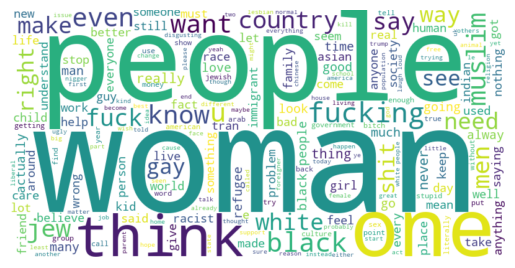

In [30]:
# Word cloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text = ' '.join(data['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [32]:
data.to_csv('Preprocessed_whitespace_tokenization_dataset.csv', index=False)